https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

Cookie Cats is a popular puzzle game developed by Tactile Entertainment, first released on April 27, 2016. With over 1 million downloads on Google Play alone, the game features a classic "connect-three" mechanic, where players match tiles of the same color to clear the board and advance through increasingly challenging levels.

As players progress through Cookie Cats, they occasionally hit gates that either require a wait or an in-app purchase to continue. These gates not only encourage spending but also give players a forced break, which may help sustain long-term enjoyment.

Originally, the first gate appeared at level 30. In this dataset, players have been randomly assigned to a Control Group (version 1, gate at level 30 as originally designed) and a Treatment Group (version 2, with the gate moved to level 40).


The dataset includes features such as the number of rounds played, and whether a player returned to the game the day after installation (Day 1 retention) and one week later (Day 7 retention). We’ll apply statistical methods to analyze whether this change had a significant impact on player behavior.

We'll start with some exploratory data analysis (EDA) to get a better understanding of the dataset and its key features.

# Libraries and Dataset Import

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
df = pd.read_csv('cookie_cats.csv')

# Exploratory Data Analysis

---



In [70]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [71]:
df.shape

(90189, 5)

In [72]:
df['userid'].value_counts()

,count
userid,
9999861,1
116,1
337,1
377,1
483,1
...,...
2451,1
2392,1
2382,1


The dataset contains 90,189 user records, and there are no duplicate entries based on user ID.

**Features**


*   userid : A unique identifier assigned to each player.

*   version : Indicates the experimental group the player was assigned to, either gate_30 or gate_40.

*   sum_gamerounds : The total number of game rounds played by the player during the first **14 days** after install.

*   retention_1 : A boolean value indicating whether the player returned to play the game one day after installation.

*   retention_7 : A boolean value indicating whether the player returned to play the game seven days after installation.

In [73]:
df.isnull().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


No NaN values

In [75]:
df['version'].value_counts()

,count
version,
gate_40,45489
gate_30,44700


In [76]:
44700/90189

0.49562585237667567

The dataset is very well balanced between the gate_30 and gate_40 versions, with a slightly higher number of players in the gate_40 group, the split is nearly 50/50

In [77]:
df.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
1%,1.009289e+05,0.000000
5%,5.029350e+05,1.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
95%,9.492762e+06,221.000000


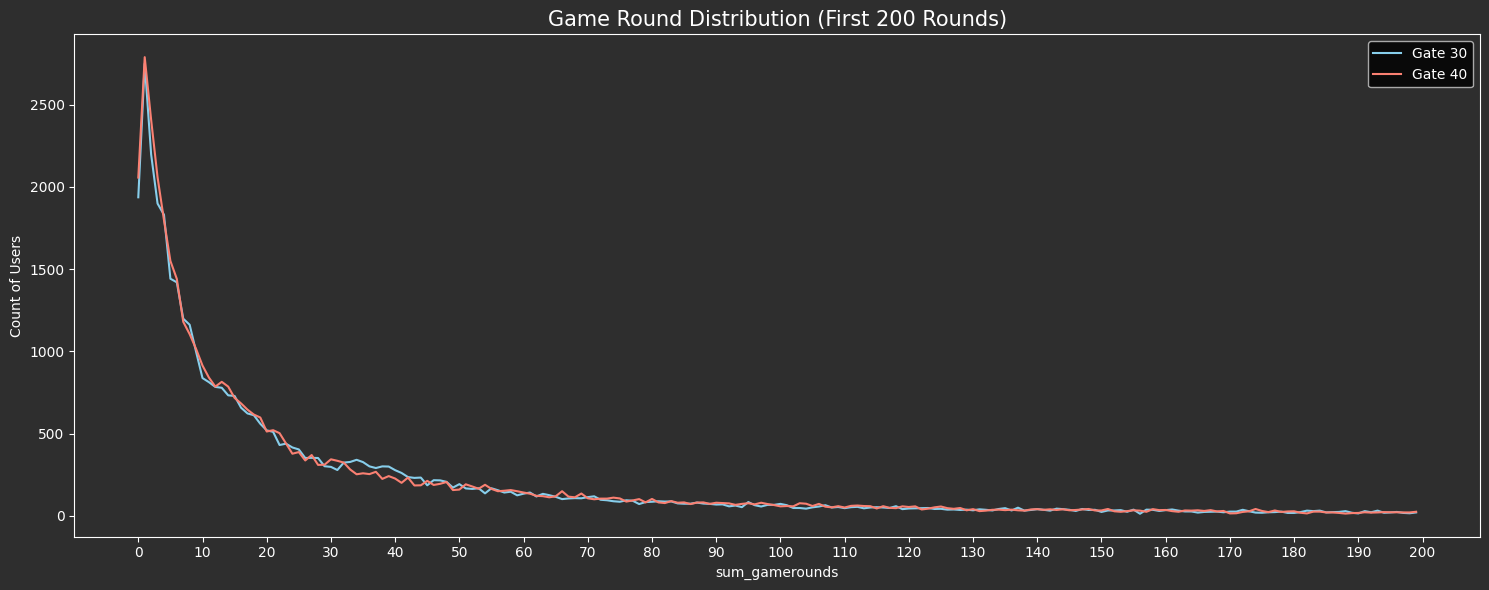

In [78]:
plt.figure(figsize=(15, 6), facecolor='#2e2e2e')
ax = plt.gca()
ax.set_facecolor('#2e2e2e')
plot_30[:200].plot(label="Gate 30", color='skyblue', ax=ax)
plot_40[:200].plot(label="Gate 40", color='salmon', ax=ax)
plt.title("Game Round Distribution (First 200 Rounds)", fontsize=15)
plt.xlabel("sum_gamerounds")
plt.ylabel("Count of Users")
plt.legend()
plt.xticks(ticks=range(0, 201, 10))
plt.tight_layout()
plt.show()

As we can see, the blue line (Gate 30) and the red line (Gate 40) follow a very similar pattern overall. However, if we zoom in on the 30–40 game round range, an interesting shift occurs: the blue line clearly surpasses the red.

This could suggest that, although players in Gate 30 encountered the gate earlier, those who pushed through it were more engaged, resulting in more users continuing beyond round 30 compared to Gate 40.

In contrast, players in Gate 40 had not yet encountered the gate during this range, yet their drop-off rate was slightly higher. After round 40, both groups return to a similar declining trend, which is expected as fewer players reach higher round counts.

Text(0.5, 1.0, 'Boxplot of Game Rounds by Version')

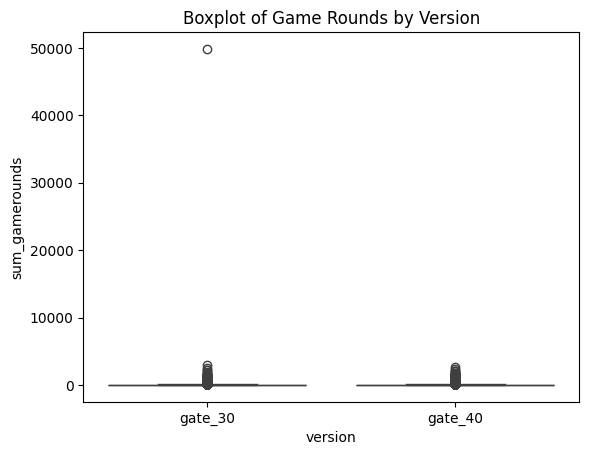

In [80]:
plt.style.use('default')
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title("Boxplot of Game Rounds by Version")

As we can see, there is a significant outlier in the data. While half of the players did not exceed 16 game rounds, one user played an astonishing 49,854 rounds, which heavily skews the distribution.

Since we're focusing on casual player behavior, the extreme outlier with 49,854 game rounds would heavily skew the distribution without providing meaningful insights. Therefore, we will remove it from the analysis.

In [81]:
df_clean = df[df['sum_gamerounds'] < 5000]

In [82]:
df_clean.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
1%,1.009286e+05,0.000000
5%,5.029288e+05,1.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
95%,9.492762e+06,221.000000


In [83]:
percentiles = [0.01, 0.05, 0.25, 0.5, 0.6, 0.7, 0.75, 0.95, 0.99]
# Group by version and calculate percentiles for sum_gamerounds
summary = df_clean.groupby('version')['sum_gamerounds'].quantile(percentiles).unstack()
summary.index.name = 'Version'
summary.columns = [f"{int(p*100)}%" for p in percentiles]
extra_stats = df_clean.groupby('version')['sum_gamerounds'].agg(['mean', 'std', 'min', 'max'])
# We combine both in a table
final_summary = pd.concat([summary, extra_stats], axis=1)
final_summary

,1%,5%,25%,50%,60%,70%,75%,95%,99%,mean,std,min,max
gate_30,0.0,1.0,5.0,17.0,26.0,40.0,50.0,222.0,493.00,51.342111,102.057598,0,2961
gate_40,0.0,1.0,5.0,16.0,25.0,40.0,52.0,220.0,492.12,51.298776,103.294416,0,2640


In [84]:
df= df_clean

# Retention

---



Overall, there's no significant difference in how far players progressed in either version. Up to the 50th percentile, gate_30 performs slightly better, while at the 75th percentile, gate_40 takes a small lead. Around the 90th percentile, gate_30 regains a slight edge.

The mean number of rounds played is nearly identical: 51.34 for gate_30 and 51.30 for gate_40. Even after removing the extreme outlier, gate_30 still has a slightly higher maximum round count (2961 vs. 2640), suggesting slightly more upper-end engagement, though the difference is minimal.



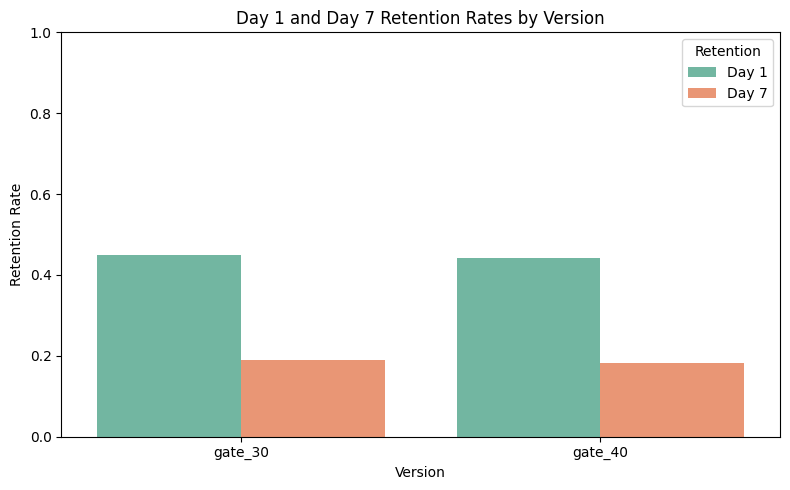

In [86]:
retention_summary = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()
retention_melted = retention_summary.melt(id_vars='version',
                                           value_vars=['retention_1', 'retention_7'],
                                           var_name='Retention',
                                           value_name='Rate')


retention_melted['Retention'] = retention_melted['Retention'].map({
    'retention_1': 'Day 1',
    'retention_7': 'Day 7'
})


plt.figure(figsize=(8, 5))
sns.barplot(data=retention_melted, x='version', y='Rate', hue='Retention', palette='Set2')

plt.title("Day 1 and Day 7 Retention Rates by Version")
plt.ylabel("Retention Rate")
plt.xlabel("Version")
plt.ylim(0, 1)
plt.legend(title="Retention")
plt.tight_layout()
plt.show()

In [87]:
df.groupby('version')[['retention_1', 'retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


In [88]:
# Total users per version
total_users = df['version'].value_counts().sort_index()

# Number of users who returned on Day 1 and Day 7
retention_counts = df.groupby('version')[['retention_1', 'retention_7']].sum()

# Retention rates (as proportions)
retention_rates = df.groupby('version')[['retention_1', 'retention_7']].mean()

# Combine all in one DataFrame
summary = pd.DataFrame()
summary['total_users'] = total_users
summary['retention_1'] = retention_counts['retention_1']
summary['retention_7'] = retention_counts['retention_7']
summary['retention_1_rate'] = retention_rates['retention_1']
summary['retention_7_rate'] = retention_rates['retention_7']

summary

,total_users,retention_1,retention_7,retention_1_rate,retention_7_rate
version,,,,,
gate_30,44699,20034,8501,0.448198,0.190183
gate_40,45489,20119,8279,0.442283,0.182000


**Version 1 --- Gate 30**

*   Retention_1 = 44.82% of players returned the next day
*   Retention_7 = 19.02% returned one week later

**Version 2 --- Gate 40**

*   Retention_1 = 44.23% returned the next day
*   Retention_7 = 18.20% returned after one week








Though the retention is again almost the same, there is slightly better player return on gate 1 both on one day after, and week

In [89]:
condition = (df['retention_1'] == True) & (df['retention_7'] == False)
result = df[condition].groupby('version').size()

print("Users who returned on Day 1 but NOT after a week:")
print(result)

Users who returned on Day 1 but NOT after a week:
version
gate_30    13358
gate_40    13613
dtype: int64


In [91]:
both_retained = df[(df['retention_1']) & (df['retention_7'])]
both_retained_count = both_retained.groupby('version').size()
print(both_retained_count)


version
gate_30    6676
gate_40    6506
dtype: int64


# Hypothesis Testing

---



Although the difference is small, gate_30 (version 1) had around 150 more players who returned on both Day 1 and Day 7 compared to gate_40 (version 2) ,despite version 2 having 789 more total users. This could be a point for gate_30.

Let's move on to our **hypothesis testing** to understand whether changing the gate from level 30 to 40 had a measurable impact on player retention.

In [92]:
from statsmodels.stats.proportion import proportions_ztest

We will use a two-proportion z-test to compare retention rates between the two groups.

Our null hypothesis (H₀) is that there is no difference in retention between players in Gate 30 and Gate 40, that both groups have the same probability of returning.

Our alternative hypothesis (H₁) is that there is a difference in retention between the two versions, meaning the gate change impacted player behavior.

To evaluate the hypotheses, we look at the p-value produced by the z-test. The p-value tells us the probability of observing a difference in retention as large as the one in our data, assuming the null hypothesis is true.

If the p-value is less than 0.05, we consider the result statistically significant and reject the null hypothesis. This means the difference in retention is unlikely to be due to chance.

If the p-value is greater than or equal to 0.05, we fail to reject the null hypothesis, suggesting there isn’t enough evidence to say the gate change had a meaningful impact on retention.

In [93]:
vers = ['retention_1', 'retention_7']
for i in vers:
    successes = df.groupby('version')[i].sum().sort_index().values
    n_obs = df['version'].value_counts().sort_index().values
    z_stat, p_val = proportions_ztest(successes, n_obs)
    print(f"\nZ-test for {i}:")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"P-value: {p_val:.4f}")


Z-test for retention_1:
Z-statistic: 1.7871
P-value: 0.0739

Z-test for retention_7:
Z-statistic: 3.1574
P-value: 0.0016


As we can see from the z-test results, for retention_1, the p-value is greater than 0.05, indicating that the difference in next-day retention between Gate 30 and Gate 40 is not statistically significant. This suggests that changing the gate did not have a meaningful impact on whether players returned the following day.


However, for retention_7, the p-value is less than 0.05, which indicates that the difference is statistically significant. This provides some evidence that the gate 30 setup is slightly better.

#  Insights Summary
---









Combining insights from both our exploratory data analysis and hypothesis testing, we can conclude that Version 1 (gate at level 30) results in slightly better player retention.

While the difference in Day 1 retention was not statistically significant (p-value > 0.05), this could be because many players did not reach level 30 on their first day. As a result, they weren’t yet exposed to the gate, meaning the experimental change hadn’t had a chance to influence their behavior.
In contrast, the statistically significant result for Day 7 retention suggests that once players do encounter the gate, the placement at level 30 may help retain more of them in the following days.

One possible reason why gate 30 outperformed gate 40 could be that level 30 is a more natural point for a forced break. By that stage, players may still feel engaged and motivated to continue. In contrast, placing the gate at level 40 might come too late, at a point where some players are already starting to lose interest or fatigue, leading them to drop off before ever reaching the gate. This means fewer players actually experience the gate at all, and those who do might not be as motivated to continue

# Additional Data That Could Be Interesting
---



1.   The exact day of the game download

Understanding which day of the week players installed the game could reveal behavioral trends. For example, users may spend more time playing on weekends or holidays, potentially improving early retention.

2.  What if the gate was placed earlier, say at level 20?

It would be valuable to test whether introducing the gate sooner would improve or hurt engagement. Would it filter out casual users too early, or help form habits faster?

3.   Daily player activity

Knowing how many levels or rounds a player completes each day would give us a much clearer view of progression speed, session frequency, and overall engagement patterns.









